# Feature Engineering - Expedia Hotel Recommendation

This notebook focuses on creating and evaluating new features for the Expedia hotel recommendation dataset.

## 1. Setup and Data Loading

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid') # Using a more current style
sns.set_palette('husl')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [18]:
# Assuming your data loader is in the src directory relative to the workspace root
import sys
# IMPORTANT: Adjust this path if your 'src' directory is located elsewhere relative to 'notebooks'
sys.path.append('../') # This makes the 'src' directory (and its submodules) available for import

try:
    from src.data.data_loader import load_data 
    print("Successfully imported load_data from src.data.data_loader")
except ImportError as e:
    print(f"Could not import load_data: {e}")
    print(f"Current sys.path: {sys.path}")
    print("Please ensure 'src/data/data_loader.py' exists and the path is correct.")
    # Fallback or placeholder if data_loader is not found
    def load_data(path, nrows=None):
        print(f"Fallback: Attempting to load data from: {path}")
        try:
            return pd.read_csv(path, nrows=nrows)
        except FileNotFoundError:
            print(f"Fallback Error: File not found at {path}")
            return pd.DataFrame()

# Load the training data (adjust path as needed)
# The path should be relative to the WORKSPACE ROOT, not the notebook file itself.
TRAIN_DATA_PATH = '../data/train.csv' # Path from workspace root
print(f"Attempting to load data from: {TRAIN_DATA_PATH}")
train_df = load_data(TRAIN_DATA_PATH, nrows=None) # Load the full dataset or a large sample

if not train_df.empty:
    print(f"Training data shape: {train_df.shape}")
    display(train_df.head())
else:
    print("Training data failed to load. Please check the path and data_loader configuration.")

Successfully imported load_data from src.data.data_loader
Attempting to load data from: ../data/train.csv
Successfully loaded data from ../data/train.csv. Shape: (4958347, 54)
Training data shape: (4958347, 54)


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


## 2. Investigate `srch_destination_id` vs `prop_country_id`

In [ ]:
if 'train_df' in locals() and not train_df.empty and 'srch_destination_id' in train_df.columns and 'prop_country_id' in train_df.columns:
    print("Investigating if srch_destination_id could be a country ID by comparing with prop_country_id...")
    # Calculate the percentage of times srch_destination_id matches prop_country_id
    matches = (train_df['srch_destination_id'] == train_df['prop_country_id']).sum()
    total_rows = len(train_df)
    percentage_match = (matches / total_rows) * 100 if total_rows > 0 else 0
    
    print(f"Number of times srch_destination_id matches prop_country_id: {matches}")
    print(f"Total rows analyzed: {total_rows}")
    print(f"Percentage of matches: {percentage_match:.2f}%")
    
    # Further analysis: Check unique values and distributions if they don't match often
    if percentage_match < 90: # Using a threshold to decide if further investigation is needed
        print("\nSince the match percentage is not very high, let's look at the unique values count for each:\n")
        print(f"Unique srch_destination_id values: {train_df['srch_destination_id'].nunique()}")
        print(f"Unique prop_country_id values: {train_df['prop_country_id'].nunique()}")
        
        mismatched_df = train_df[train_df['srch_destination_id'] != train_df['prop_country_id']][['srch_destination_id', 'prop_country_id']]
        if not mismatched_df.empty:
            print("\nSample of rows where srch_destination_id != prop_country_id (first 5):")
            display(mismatched_df.head())
            
            print("\nValue counts for srch_destination_id in mismatched rows (top 5):")
            display(mismatched_df['srch_destination_id'].value_counts().head())
            
            print("\nValue counts for prop_country_id in mismatched rows (top 5):")
            display(mismatched_df['prop_country_id'].value_counts().head())
        else:
            if total_rows > 0: # Only print this if we actually had data to compare
                print("\nAll srch_destination_id values match prop_country_id (this is unexpected given the percentage).")
else:
    print("Skipping srch_destination_id vs prop_country_id analysis: DataFrame is not loaded or required columns are missing.")

## 3. Investigate Family Preference for Brand Hotels (`prop_brand_bool`)

In [ ]:
if 'train_df' in locals() and not train_df.empty and 'srch_children_count' in train_df.columns and 'prop_brand_bool' in train_df.columns:
    print("Investigating family preference for brand hotels (prop_brand_bool)...")

    # Create a boolean column for 'is_family_search'
    # Ensure srch_children_count is integer, handle NaNs by filling with 0 (no children)
    train_df['is_family_search'] = train_df['srch_children_count'].fillna(0).astype(int) > 0

    # Calculate the proportion of brand hotels (prop_brand_bool == 1) for family searches vs. non-family searches
    # prop_brand_bool: +1 if the hotel is part of a major hotel chain; 0 if it is an independent hotel
    brand_preference_by_family_status = train_df.groupby('is_family_search')['prop_brand_bool'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
    
    print("\nProportion of Listings by Hotel Type (Brand vs. Non-Brand) and Search Type (%):\n")
    if 1 in brand_preference_by_family_status.columns and 0 in brand_preference_by_family_status.columns:
        # Rename columns and index for clarity
        display_table = brand_preference_by_family_status.rename(
            columns={0: 'Non-Brand Hotel (%)', 1: 'Brand Hotel (%)'},
            index={False: 'Search without Children', True: 'Search with Children'}
        )
        display(display_table)
        
        # Visualization
        if not display_table.empty:
            plot_table = display_table[['Brand Hotel (%)', 'Non-Brand Hotel (%)']]
            plot_table.plot(kind='bar', figsize=(10, 7), stacked=False)
            plt.title('Hotel Type Preference: Searches With vs. Without Children')
            plt.ylabel('Percentage of Listings (%)')
            plt.xlabel('Search Type')
            plt.xticks(rotation=0)
            plt.legend(title='Hotel Type')
            plt.tight_layout()
            plt.show()
        else:
            print("No data to plot.")

    elif 1 in brand_preference_by_family_status.columns: # Only Brand hotels found in one or both groups
        display_table = brand_preference_by_family_status.rename(
            columns={1: 'Brand Hotel (%)'},
            index={False: 'Search without Children', True: 'Search with Children'}
        )
        if 0 not in display_table.columns:
             display_table['Non-Brand Hotel (%)'] = 0
        display(display_table[['Brand Hotel (%)', 'Non-Brand Hotel (%)']])
        print("Note: 'Non-Brand Hotel (%)' might be 0 if no non-brand hotels were found for these groups.")

    elif 0 in brand_preference_by_family_status.columns: # Only Non-Brand hotels found
        display_table = brand_preference_by_family_status.rename(
            columns={0: 'Non-Brand Hotel (%)'},
            index={False: 'Search without Children', True: 'Search with Children'}
        )
        if 1 not in display_table.columns:
            display_table['Brand Hotel (%)'] = 0
        display(display_table[['Brand Hotel (%)', 'Non-Brand Hotel (%)']])
        print("Note: 'Brand Hotel (%)' might be 0 if no brand hotels were found for these groups.")
    else:
        print("Could not generate detailed brand preference table. Raw counts per group:")
        print(train_df.groupby('is_family_search')['prop_brand_bool'].value_counts().unstack(fill_value=0))

    # Clean up the added column if you don't need it for further immediate analysis
    # del train_df['is_family_search'] 
else:
    print("Skipping family preference analysis: DataFrame is not loaded or 'srch_children_count'/'prop_brand_bool' columns are missing.")

## 4. Length of Stay vs. Booking Window Analysis

In [ ]:
if 'train_df' in locals() and not train_df.empty and 'srch_length_of_stay' in train_df.columns and 'srch_booking_window' in train_df.columns:
    print("Analyzing relationship between Length of Stay and Booking Window...")
    
    # Remove rows with NaN in these specific columns for this analysis
    analysis_df = train_df[['srch_length_of_stay', 'srch_booking_window']].dropna()
    
    # Cap values for better visualization (extreme outliers can skew the plot)
    # These caps are arbitrary and can be adjusted based on data distribution
    analysis_df['srch_length_of_stay_capped'] = analysis_df['srch_length_of_stay'].clip(upper=30) # Cap length of stay at 30 days
    analysis_df['srch_booking_window_capped'] = analysis_df['srch_booking_window'].clip(upper=365) # Cap booking window at 1 year
    
    # Calculate correlation
    correlation = analysis_df['srch_length_of_stay'].corr(analysis_df['srch_booking_window'])
    print(f"\nCorrelation between Length of Stay and Booking Window: {correlation:.4f}")
    
    # Hexbin plot for density visualization
    plt.figure(figsize=(12, 8))
    hb = plt.hexbin(analysis_df['srch_booking_window_capped'], analysis_df['srch_length_of_stay_capped'], gridsize=50, cmap='YlGnBu', mincnt=1)
    plt.colorbar(hb, label='Count in Bin')
    plt.xlabel('Booking Window (Days - Capped at 365)')
    plt.ylabel('Length of Stay (Nights - Capped at 30)')
    plt.title('Density Plot: Length of Stay vs. Booking Window')
    plt.show()
    
    # Scatter plot for a smaller sample for clearer individual points
    sample_df = analysis_df.sample(n=min(5000, len(analysis_df)), random_state=42)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=sample_df, x='srch_booking_window_capped', y='srch_length_of_stay_capped', alpha=0.5)
    plt.xlabel('Booking Window (Days - Capped at 365)')
    plt.ylabel('Length of Stay (Nights - Capped at 30)')
    plt.title('Scatter Plot: Length of Stay vs. Booking Window (Sampled & Capped)')
    plt.show()
else:
    print("Skipping Length of Stay vs. Booking Window analysis: DataFrame not loaded or required columns missing.")

## 5. Price Sensitivity and Star Rating Analysis

In [ ]:
if 'train_df' in locals() and not train_df.empty and 'price_usd' in train_df.columns and 'prop_starrating' in train_df.columns:
    print("Analyzing Price USD by Property Star Rating...")
    
    # Filter out extreme price outliers for better visualization in box plot
    # Using a quantile range, e.g., 0.01 to 0.99
    price_low_quantile = train_df['price_usd'].quantile(0.01)
    price_high_quantile = train_df['price_usd'].quantile(0.99)
    analysis_df_price_star = train_df[(train_df['price_usd'] >= price_low_quantile) & (train_df['price_usd'] <= price_high_quantile)]
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=analysis_df_price_star, x='prop_starrating', y='price_usd', palette='viridis')
    plt.xlabel('Property Star Rating')
    plt.ylabel('Price USD (Outliers Filtered for Plot)')
    plt.title('Distribution of Price USD by Property Star Rating')
    plt.ylim(0, analysis_df_price_star['price_usd'].max() * 1.05) # Adjust y-limit slightly above max for clarity
    plt.show()
    
    # Also analyze visitor_hist_adr_usd vs price_usd
    if 'visitor_hist_adr_usd' in train_df.columns:
        print("\nAnalyzing Visitor Historical ADR vs. Current Search Price USD...")
        hist_price_df = train_df[['visitor_hist_adr_usd', 'price_usd']].dropna()
        
        # Filter outliers for these as well for plotting
        hist_adr_low = hist_price_df['visitor_hist_adr_usd'].quantile(0.01)
        hist_adr_high = hist_price_df['visitor_hist_adr_usd'].quantile(0.99)
        price_low = hist_price_df['price_usd'].quantile(0.01)
        price_high = hist_price_df['price_usd'].quantile(0.99)
        
        plot_hist_price_df = hist_price_df[
            (hist_price_df['visitor_hist_adr_usd'] >= hist_adr_low) & (hist_price_df['visitor_hist_adr_usd'] <= hist_adr_high) &
            (hist_price_df['price_usd'] >= price_low) & (hist_price_df['price_usd'] <= price_high)
        ]
        
        correlation_hist_price = plot_hist_price_df['visitor_hist_adr_usd'].corr(plot_hist_price_df['price_usd'])
        print(f"Correlation between Visitor Historical ADR and Current Price USD (filtered): {correlation_hist_price:.4f}")
        
        plt.figure(figsize=(12, 8))
        # Using hexbin for density as scatter can be too dense
        hb_hist = plt.hexbin(plot_hist_price_df['visitor_hist_adr_usd'], plot_hist_price_df['price_usd'], gridsize=40, cmap='Blues', mincnt=1)
        plt.colorbar(hb_hist, label='Count in Bin')
        plt.xlabel('Visitor Historical ADR (USD - Filtered)')
        plt.ylabel('Current Search Price (USD - Filtered)')
        plt.title('Density: Visitor Historical ADR vs. Current Search Price')
        plt.show()
    else:
        print("\nSkipping Visitor Historical ADR analysis: 'visitor_hist_adr_usd' column missing.")
else:
    print("Skipping Price USD vs. Star Rating analysis: DataFrame not loaded or required columns missing.")

## 6. Impact of Promotions on Hotel Characteristics

In [ ]:
if 'train_df' in locals() and not train_df.empty and 'promotion_flag' in train_df.columns and 'prop_starrating' in train_df.columns:
    print("Analyzing Impact of Promotions on Property Star Rating Distribution...")
    
    plt.figure(figsize=(12, 7))
    sns.countplot(data=train_df, x='prop_starrating', hue='promotion_flag', palette={0: 'skyblue', 1: 'salmon'})
    plt.xlabel('Property Star Rating')
    plt.ylabel('Number of Listings')
    plt.title('Distribution of Property Star Ratings by Promotion Flag')
    legend_labels = ['No Promotion', 'Promotion']
    plt.legend(title='Promotion Status', labels=legend_labels)
    plt.show()
    
    # Proportion of promoted listings within each star rating
    promo_by_star = train_df.groupby('prop_starrating')['promotion_flag'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
    if 1 in promo_by_star.columns: # Check if there are any promotions
        promo_by_star = promo_by_star.rename(columns={0: 'No Promo (%)', 1: 'Promo (%)'})
        print("\nPercentage of Promoted Listings within Each Star Rating Category:\n")
        display(promo_by_star)
        
        if 'Promo (%)' in promo_by_star.columns:
            promo_by_star['Promo (%)'].plot(kind='bar', figsize=(10,6), color='salmon')
            plt.title('Percentage of Promoted Listings by Star Rating')
            plt.xlabel('Property Star Rating')
            plt.ylabel('Percentage Promoted (%)')
            plt.xticks(rotation=0)
            plt.show()
    else:
        print("\nNo promoted listings found in the dataset to analyze by star rating.")
        
else:
    print("Skipping Promotion Impact analysis: DataFrame not loaded or required columns missing.")

## 7. Correlation with Target Variable (`booking_bool`)

In [ ]:
if 'train_df' in locals() and not train_df.empty and 'booking_bool' in train_df.columns:
    print("Calculating correlation of features with booking_bool...")
    
    # Select numerical features and boolean-like features that can be treated as numeric
    # Exclude direct leakers like 'gross_booking_usd' and 'click_bool'
    # Also exclude 'date_time' for direct correlation, and high-cardinality IDs that are not ordinal
    potential_features = train_df.select_dtypes(include=[np.number, 'bool']).columns.tolist()
    
    # Features to exclude from correlation analysis with booking_bool
    # 'srch_id' is an identifier, not a feature for this type of correlation.
    # 'gross_booking_usd' and 'click_bool' are direct leakers or part of the target definition.
    features_to_exclude = ['srch_id', 'gross_booking_usd', 'click_bool']
    
    # For competitor features, fill NaNs to allow correlation calculation (e.g., with 0 or a specific value if meaningful)
    # For simplicity, we'll create a copy and fill NaNs for comp features with 0 for correlation purposes.
    df_for_corr = train_df.copy()
    comp_cols = [col for col in df_for_corr.columns if 'comp' in col and ('rate' in col or 'inv' in col or 'diff' in col)]
    for col in comp_cols:
        if df_for_corr[col].isnull().any():
            df_for_corr[col] = df_for_corr[col].fillna(0) # Example: fill with 0 (neutral)
            
    numeric_and_boolean_features = []
    for col in df_for_corr.columns:
        if col not in features_to_exclude and col != 'booking_bool':
            if df_for_corr[col].dtype in [np.number, 'int64', 'float64', 'bool']:
                 numeric_and_boolean_features.append(col)
            elif pd.api.types.is_numeric_dtype(df_for_corr[col]): # Catch other numeric types like Int64
                 numeric_and_boolean_features.append(col)

    if not numeric_and_boolean_features:
        print("No suitable numeric or boolean features found for correlation analysis with booking_bool.")
    else:
        # Calculate correlations
        correlations = df_for_corr[numeric_and_boolean_features + ['booking_bool']].corr()['booking_bool'].sort_values(ascending=False)
        # Remove the booking_bool self-correlation
        correlations = correlations.drop('booking_bool', errors='ignore')
        
        print("\nTop/Bottom Correlations with booking_bool:\n")
        display(correlations)
        
        # Visualization
        plt.figure(figsize=(10, max(8, len(correlations) * 0.3))) # Adjust height based on number of features
        sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
        plt.title('Feature Correlation with booking_bool')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Feature')
        plt.axvline(x=0, color='grey', lw=1)
        plt.tight_layout()
        plt.show()
else:
    print("Skipping correlation with booking_bool: DataFrame not loaded or 'booking_bool' column missing.")

## 8. Customer Type Analysis (New vs. Recurring) and Booking Behavior

In [19]:
if 'train_df' in locals() and not train_df.empty and 'visitor_hist_starrating' in train_df.columns and 'visitor_hist_adr_usd' in train_df.columns:
    print("Creating 'is_recurring_customer' feature...")
    
    # A customer is considered recurring if they have a historical star rating OR historical average daily rate.
    condition = train_df['visitor_hist_starrating'].notna() | train_df['visitor_hist_adr_usd'].notna()
    train_df['is_recurring_customer'] = condition.astype(int)
    
    print("Value counts for 'is_recurring_customer':")
    display(train_df['is_recurring_customer'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
    display(train_df['is_recurring_customer'].value_counts())
else:
    print("Skipping 'is_recurring_customer' feature creation: DataFrame not loaded or required history columns missing.")

Creating 'is_recurring_customer' feature...
Value counts for 'is_recurring_customer':


is_recurring_customer
0    94.9%
1     5.1%
Name: proportion, dtype: object

is_recurring_customer
0    4705326
1     253021
Name: count, dtype: int64


Analyzing booking behavior by customer type (New vs. Recurring)...

Booking Rate by Customer Type:



,is_recurring_customer,Booking Rate (%)
0,New Customer,2.746994
1,Recurring Customer,3.610372


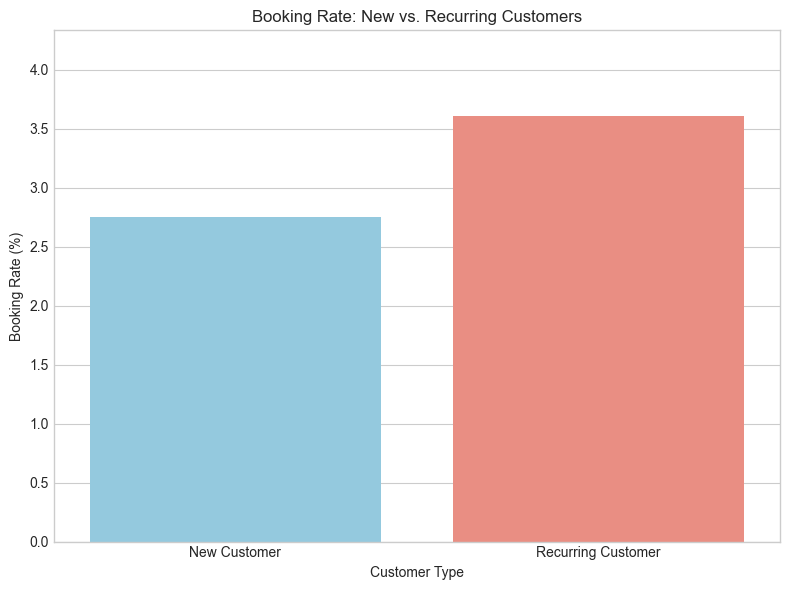


Contingency Table for Chi-squared Test:


booking_bool,0,1
is_recurring_customer,,
0,4576071,129255
1,243886,9135


Chi-squared statistic: 659.3690
P-value: 0.0000
The p-value is less than 0.05, suggesting a statistically significant association between customer type and booking behavior.


In [20]:
if 'train_df' in locals() and not train_df.empty and 'is_recurring_customer' in train_df.columns and 'booking_bool' in train_df.columns:
    print("\nAnalyzing booking behavior by customer type (New vs. Recurring)...")
    
    # Calculate booking rate for each customer type
    booking_rate_by_customer_type = train_df.groupby('is_recurring_customer')['booking_bool'].mean().mul(100).reset_index()
    booking_rate_by_customer_type['is_recurring_customer'] = booking_rate_by_customer_type['is_recurring_customer'].map({0: 'New Customer', 1: 'Recurring Customer'})
    booking_rate_by_customer_type = booking_rate_by_customer_type.rename(columns={'booking_bool': 'Booking Rate (%)'})
    
    print("\nBooking Rate by Customer Type:\n")
    display(booking_rate_by_customer_type)
    
    # Visualization
    plt.figure(figsize=(8, 6))
    sns.barplot(data=booking_rate_by_customer_type, x='is_recurring_customer', y='Booking Rate (%)', palette={'New Customer': 'skyblue', 'Recurring Customer': 'salmon'})
    plt.title('Booking Rate: New vs. Recurring Customers')
    plt.ylabel('Booking Rate (%)')
    plt.xlabel('Customer Type')
    plt.ylim(0, max(booking_rate_by_customer_type['Booking Rate (%)']) * 1.2 if not booking_rate_by_customer_type.empty else 10) # Dynamic y-limit
    plt.tight_layout()
    plt.show()
    
    # Chi-squared test for independence (optional, for statistical significance)
    from scipy.stats import chi2_contingency
    contingency_table = pd.crosstab(train_df['is_recurring_customer'], train_df['booking_bool'])
    print("\nContingency Table for Chi-squared Test:")
    display(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    if p < 0.05:
        print("The p-value is less than 0.05, suggesting a statistically significant association between customer type and booking behavior.")
    else:
        print("The p-value is not less than 0.05, suggesting no statistically significant association (or insufficient evidence). ")

else:
    print("\nSkipping analysis of booking behavior by customer type: 'is_recurring_customer' or 'booking_bool' column missing, or DataFrame not loaded.")